<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###All important libraries/modules that may be needed:
1. torchvision
2. torchvision.datasets: has a range of toy datasets for different purposes
3. torchvision.models:
4. torchvision.transforms
5. torch.utils.data.Dataset
6. torch.utils.data.Dataloader

In [ ]:
!pip install torchmetrics


In [ ]:
#getting libraries
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#import matplotlib
import matplotlib.pyplot as plt

#import accuracy fuction
from torchmetrics.classification import MulticlassAccuracy

#chacking versions
print("PyTorch version:", torch.__version__, "Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0+cu121 Torchvision version: 0.16.0+cu121


####Getting Training and Testing Data from Torchvision.datasets

In [ ]:
train_data=datasets.FashionMNIST(root="Fashion_Data",#telling where to store the data
                          train=True,#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this#not necessary to use here as we are just assigning None value to it(labels dont need transformation)
                          )
test_data=datasets.FashionMNIST(root="Fashion_Data",#telling where to store the data
                          train=False,#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this
                          )

100%|██████████| 26421880/26421880 [00:01<00:00, 17487590.54it/s]


Extracting Fashion_Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Fashion_Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300626.25it/s]


Extracting Fashion_Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Fashion_Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5497748.93it/s]


Extracting Fashion_Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Fashion_Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13657354.20it/s]

Extracting Fashion_Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Fashion_Data/FashionMNIST/raw



In [ ]:
data, label= train_data[12]
data.shape, label #output tells shape of data and the label which is an integer
#first index of shape gives number of colour channels, if its 3 then image is in RGB

(torch.Size([1, 28, 28]), 5)

Checking Length of Train and Test dataset

In [ ]:
train_data.__len__(),test_data.__len__() #find dataset specific methods from source code

(60000, 10000)

In [ ]:
class_names=train_data.classes #returns a list of names of classes

Printing the data in dataset labels

In [ ]:
labels=[]
for i in range(train_data.__len__()):
  data,label=train_data[i]
  labels.append(label)
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Visualizing Data

Image Shape:torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Bag')

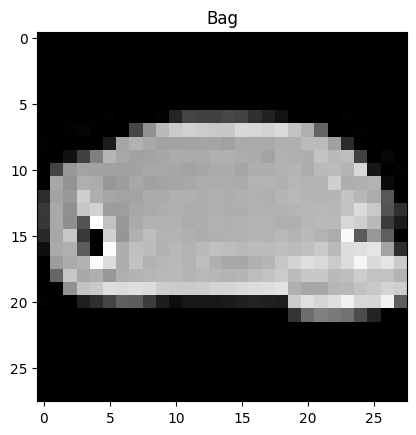

In [ ]:
import matplotlib.pyplot as plt
image,label=train_data[5555]
print(f"Image Shape:{data.shape}")
image=image.view(image.shape[1],image.shape[2], image.shape[0])#putting colour map in  the last index so imshow doesnt show any error
plt.imshow(image, cmap='gray')
plt.title(class_names[label])

Making Batches


In [ ]:
from torch.utils.data import DataLoader
#for large datasets its computationally faster to work in batches rather than working with individual datasets
#setting batch size hyperparameter
BATCH_SIZE= 32

train_dataloader=DataLoader(train_data,#target dataset
                            batch_size=BATCH_SIZE,#batch size
                            shuffle=True)#whether to shuffle the datapoints or not so that neural network does not get trained on some unobvious pattern present in ordering of data points
test_dataloader=DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)#can make it shuffle but its not necessary and will add another calculation step in every epoch
print(train_dataloader, test_dataloader)
print(len(train_dataloader), len(test_dataloader))


<torch.utils.data.dataloader.DataLoader object at 0x7e1f0a0af730> <torch.utils.data.dataloader.DataLoader object at 0x7e1f0a0ade40>
1875 313


In [ ]:
#checking data inside data loader
train_features_batch, train_labels_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

###Build a baseline model
A baseline model is the simplest model which you start with before progressing to more complicated ones.

Here, model has one difference from previous models. A nn.Flatten layer is used to convert the data in 2 dimensions (of the image ) to one feature vector.
The data in format[C,H,W] gets converted to [C,H*W].
This is done because nn.Linear layer works better with vectors

In [ ]:
#to see how flatten layer works, create a flatten layer
flatten_layer=nn.Flatten()
x=train_features_batch[0]
output=flatten_layer(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
#building the baseline model
from torch import nn
class Fashion_Model_0(nn.Module):
  def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
    super().__init__()
    self.layers=nn.Sequential(nn.Flatten(),
                              nn.Linear(in_features=input_shape, out_features= hidden_units),
                              nn.Linear(in_features=hidden_units, out_features= output_shape))
  def forward(self,x):
    return self.layers(x)

Making first instance of the model

In [ ]:
model_0=Fashion_Model_0(input_shape=784,#as images here are 28x28=784, its hardcoded in this model
                        hidden_units=50,
                        output_shape=len(class_names))#output units will give one logit for wach member of class names
model_0.to('cpu')#keep model in cpu to begin with

Fashion_Model_0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

Defining Accuracy, Loss function and Optimizer

In [ ]:
accuracy=MulticlassAccuracy(num_classes=len(class_names))
loss_fn=nn.CrossEntropyLoss()#same as multiclass classification loss function
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)#SGD optimizer

Defining function to measure time taken for training model

In [ ]:
from timeit import default_timer as timer
def print_train_time(start:float, end: float, device: torch.device=None):

  """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

Making training and testing loop

In [ ]:
!pip install tqdm# for showing progress meter

In [ ]:
from tqdm.auto import tqdm
epochs=3#keep small at first for smaller loop time
#set random seed
torch.manual_seed(56)
#start the timer
time_start_cpu=timer()

for epoch in tqdm(range(epochs)):
  print("Epoch:", epoch)
  ##Training
  train_loss=0
  model_0.train()
  #loop through training batches
  for batch,(x,y) in enumerate(train_dataloader):
    #1. Forward Pass
    y_pred=model_0(x)

    #2. Calculate Loss
    loss= loss_fn(y_pred, y)
    train_loss+=loss#add up the loss of each sample in the batch to get loss of whole batch

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. Loss Backward
    loss.backward()

    #5. Optimizer Step
    optimizer.step()

    if batch%50==0:
      amount=(batch * len(x))/len(train_dataloader.dataset)
      print("Looked at", amount, "samples")

